<a href="https://colab.research.google.com/github/elahe-ghafari/my-final-project/blob/main/VGG16%2BViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os                       # for working with files

import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [ ]:
!pip install split-folders[full]

Split Training Data into training and validation

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
with ZipFile ('/content/drive/My Drive/melanom.zip','r') as zipObj:
  zipObj.extractall('melanom')

In [ ]:
from google.colab import files
!zip -r /content/melanom.zip /content/melanom
files.download('/content/drive/My Drive/melanom.zip')

Streaming output truncated to the last 5000 lines.
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_710.jpg (deflated 1%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_4950.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_4271.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_3930.jpg (deflated 3%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_2889.jpg (deflated 4%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_4187.jpg (deflated 1%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_2881.jpg (deflated 4%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_3655.jpg (deflated 1%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_4888.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_781.jpg (deflated 2%)
 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_dir = 'melanom/melanoma_cancer_dataset/train'
skin = os.listdir(train_dir)
skin

['malignant', 'benign']

In [ ]:
# Number of images for each diseas
nums_train = {}
nums_val = {}
for s in skin:
    nums_train[s] = len(os.listdir(train_dir + '/' + s))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
malignant,4605
benign,5000


<Axes: title={'center': 'data distribution '}, xlabel='Type of skin cancer', ylabel='Number of image'>

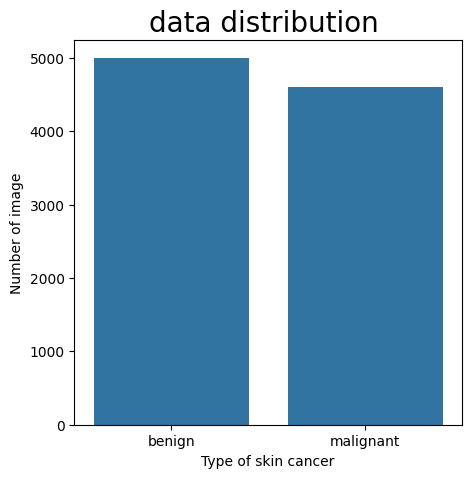

In [ ]:
plt.figure(figsize=(5,5))
plt.title('data distribution ',fontsize=20)
plt.ylabel('Number of image',fontsize=10)
plt.xlabel('Type of skin cancer',fontsize=10)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)

In [ ]:
# Function to show image
train = ImageFolder(train_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

In [ ]:
pip install transformers


Modeling

In [ ]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         #rotation_range = 0.30 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.2
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory(train_dir, subset='training', target_size=(224,224), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=True)

test_data = valid_gen.flow_from_directory(train_dir, subset='validation', target_size=(224,224), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=False)



Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


MODELvgg16+ViT

In [ ]:
!pip install keras-vit

In [ ]:
pip install tensorflow

In [ ]:
X_train = []
y_train = []

# Iterate over the generator to collect all samples and labels
for i in range(len(train_data)):
    batch_X, batch_y = train_data[i]
    X_train.append(batch_X)
    batch_y = np.argmax(batch_y, axis=1)
    y_train.append(batch_y)

# Concatenate the batches into numpy arrays
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = []
y_test = []

# Iterate over the generator to collect all samples and labels
for i in range(len(test_data)):
    batch_X, batch_y = test_data[i]
    X_test.append(batch_X)
    batch_y = np.argmax(batch_y, axis=1)
    y_test.append(batch_y)

# Concatenate the batches into numpy arrays
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [ ]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [ ]:
# import torch
# import torch.nn as nn
# import torchvision
# from torchvision.models import vgg16
# from transformers import ViTModel
# import torch.optim as optim

# Define the hybrid model with VGG16 as the backbone
class HybridModel(nn.Module):
    def __init__(self, vgg16_model, num_classes):
        super(HybridModel, self).__init__()

        # VGG16
        self.vgg16 = vgg16_model
        self.vgg16.classifier = nn.Sequential(*list(self.vgg16.classifier.children())[:-1])  # Remove the last layer (softmax)

        # Vision Transformer
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', num_channels=3)

        # Classifier
        self.classifier = nn.Linear(768 + 4096, num_classes)  # Adjust the input size of the linear layer

    def forward(self, x):
        # Forward pass through VGG16
        vgg_features = self.vgg16(x)

        # Resize VGG features to match the output size of ViT
        vgg_features = vgg_features.view(x.size(0), -1)

        # Forward pass through Vision Transformer
        vit_output = self.vit(pixel_values=x)  # Pass the original input image
        vit_output = vit_output.last_hidden_state[:, 0, :]  # Extract the [CLS] token

        # Concatenate features from VGG16 and Vision Transformer
        combined_features = torch.cat((vgg_features, vit_output), dim=1)

        # Classification
        output = self.classifier(combined_features)
        return output

# Load the pre-trained VGG16 model
vgg16_base = torchvision.models.vgg16(pretrained=True)
for param in vgg16_base.parameters():
    param.requires_grad = False

# Define the hybrid model
model_hybrid = HybridModel(vgg16_base, num_classes=2)  # Change num_classes according to your problem

# Example input
input_tensor = torch.randn(1, 3, 224, 224)  # Assuming input image size is 224x224

# Forward pass
output = model_hybrid(input_tensor)
print("Output shape:", output.shape)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_hybrid.parameters(), lr=0.0001)

# Training loop (example)
num_epochs = 10
for epoch in range(num_epochs):
    # Your training code here
    pass

# Optionally, you can print the summary of the model
print(model_hybrid)


Output shape: torch.Size([1, 2])
HybridModel(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDatase
import torch.optim as optim


# Convert your NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Create a TensorDataset from your tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define batch size for the test DataLoader
batch_size = 64

# Create the test DataLoader
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ImportError: cannot import name 'TensorDatase' from 'torch.utils.data' (/usr/local/lib/python3.10/dist-packages/torch/utils/data/__init__.py)

In [ ]:
# Define optimizer and scheduler
optimizer = optim.Adam(model_hybrid.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Example learning rate scheduler

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model_hybrid.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:  # Assuming you have a train DataLoader named 'train_loader'
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the GPU if available

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_hybrid(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * inputs.size(0)

    # Adjust learning rate if using scheduler
    scheduler.step()

    # Compute average loss for epoch
    epoch_loss = running_loss / len(train_loader.dataset)

    # Print training loss for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

    # Optionally, evaluate the model on the validation set after each epoch
    # with torch.no_grad():
    #     model_hybrid.eval()  # Set model to evaluation mode
    #     # Validation loop
    #     for inputs_val, labels_val in val_loader:  # Assuming you have a validation DataLoader named 'val_loader'
    #         inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
    #         outputs_val = model_hybrid(inputs_val)
    #         # Compute validation loss and metrics

# Evaluate the model on the test set after training
# with torch.no_grad():
#     model_hybrid.eval()  # Set model to evaluation mode
#     # Test loop
#     for inputs_test, labels_test in test_loader:  # Assuming you have a test DataLoader named 'test_loader'
#         inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
#         outputs_test = model_hybrid(inputs_test)
#         # Compute test metrics


In [ ]:
X_test.shape

(1921, 224, 224, 3)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert your NumPy arrays to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset from your tensors
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define batch size for the test DataLoader
batch_size = 64

# Create the test DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
device='cuda'

def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.permute(0, 3, 1, 2).to(device))  # Move images to GPU before passing to model
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, predictions, ground_truth

# Assuming you have a test DataLoader named 'test_loader' and device is set properly
accuracy, predictions, ground_truth = evaluate_model(model_hybrid.to(device), test_loader, device)
print(f'Test Accuracy: {accuracy:.2f}%')

# Compute other evaluation metrics (e.g., precision, recall, f1-score) using predictions and ground truth
# You can use sklearn.metrics for this purpose
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predictions))




Test Accuracy: 48.15%
              precision    recall  f1-score   support

           0       0.54      0.03      0.05      1000
           1       0.48      0.98      0.64       921

    accuracy                           0.48      1921
   macro avg       0.51      0.50      0.35      1921
weighted avg       0.51      0.48      0.33      1921



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define the ViT model
def create_vit_classifier():
    inputs = keras.Input(shape=(image_size, image_size, 3))
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(1, activation='sigmoid')(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Load and preprocess the data
# Assuming X_train, y_train, X_test, y_test are loaded and preprocessed

# Define and compile the model
vit_classifier = create_vit_classifier()

if vit_classifier is not None:
    # Compile the model with appropriate loss and metrics
    vit_classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc"),
        ],
    )

    # Train the model
    history = vit_classifier.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        class_weight={0: 1, 1: 1},  # Adjust class weights if necessary
    )

    # Evaluate the model on test data
    evaluation = vit_classifier.evaluate(X_test, y_test)
    print("Test Loss:", evaluation[0])
    print("Test Accuracy:", evaluation[1])
    print("Test Precision:", evaluation[2])
    print("Test Recall:", evaluation[3])
    print("Test AUC:", evaluation[4])

    # Plot training history
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Error: Vit classifier model not properly defined.")


NameError: name 'image_size' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Placeholder for history object
history = None

if history:
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.title("Train and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.xlim(0, len(history.history['loss']))  # Adjust x-axis limit based on number of epochs
    plt.ylim(0.0, 1.0)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Train and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.xlim(0, len(history.history['accuracy']))  # Adjust x-axis limit based on number of epochs
    plt.ylim(0.75, 1.0)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Training history is not available. Please train the model first.")


Training history is not available. Please train the model first.


In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm1 = confusion_matrix(test_data.classes, y_pred)

# Plot confusion matrix
plot_confusion_matrix(conf_mat=cm1,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

Y_pred = model_vgg16.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_data.classes, y_pred))

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(test_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()